<a href="https://colab.research.google.com/github/ahdi3/KomputasiIntelegensiaTasks6/blob/main/TaskWeek6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Ahdi Nazzalul Ahsan

NPM: 2206812956

Original Code: https://www.kaggle.com/code/scratchpad/notebook69bdbcd30a/edit



# **Twitter Sentiment Analysis with LSTM**


In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'twitter-entity-sentiment-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1520310%2F2510329%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241008%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241008T150215Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6da17ae045d7c68b8b7cae8b204e5a6bf0983e0e2c521f94825a0950eb8fbf9df8a26e023937005b99a2c10a405801489683049d94c1520ed29e81a1f4bc6fc46293c4b0031fd654d7cc71d42bfc5693add71a8b38b12807332fbb991d62bb519a4564dd50ceefc89404b0fa389c393f442a931c54ed734490a331ee6a0840fc1fde1c49d08c678cbf9d15c3dd0144886f4501e11ea1fe51882f8e1538127f596441b8c0a9baf7f3cbe7b16028058f35eedb9e1ea4a38fbf657f9e05c980894360fda39fdb134fbda6777dab55a42e91d5282e1eab58f76e208f643dea5dcc32256aa6e6a855643be38482c441a98cc79dadb2a90e6b03aa0edc6b6150ec269e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2090169 bytes downloaded
Downloaded and uncompressed: twitter-entity-sentiment-analysis
Data source import complete.


## About the data

This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

In [ ]:
!pip install keras


# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

# Data Exploring

In [ ]:
data=pd.read_csv('../input/twitter-entity-sentiment-analysis/twitter_training.csv', sep=',', names=['Tweet_ID','Entity','Sentiment','Tweet_content'])

In [ ]:
data.shape

(74682, 4)

In [ ]:
data.head(10)

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


In [ ]:
data.Entity.unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

([<matplotlib.patches.Wedge at 0x7a978eaafc70>,
 [Text(-0.8936408809046303, 0.6414093669225578, 'Negative'),
  Text(-0.39649770564254117, -1.0260553442286633, 'Positive'),
  Text(1.0532293937999033, -0.3173449921392938, 'Neutral'),
  Text(0.5716146417662045, 0.9398173765782871, 'Irrelevant')],
 [Text(-0.4874404804934347, 0.3498596546850315, '30.2%'),
  Text(-0.21627147580502246, -0.5596665513974527, '27.9%'),
  Text(0.5744887602544927, -0.17309726843961476, '24.5%'),
  Text(0.31178980459974787, 0.5126276599517929, '17.4%')])

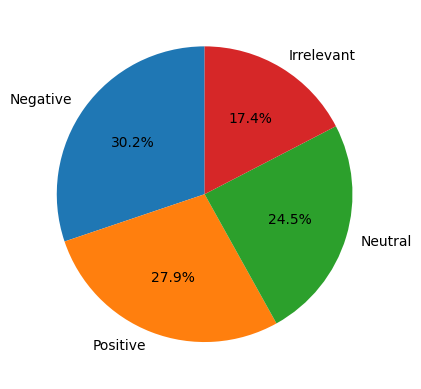

In [ ]:
plt.pie(data.Sentiment.value_counts()
,labels=['Negative','Positive','Neutral','Irrelevant'],autopct='%1.1f%%',startangle=90)

In [ ]:
data.Sentiment.value_counts()

,count
Sentiment,
Negative,22542
Positive,20832
Neutral,18318
Irrelevant,12990


# Data Cleaning

**Drop dublicated data**

In [ ]:
data.duplicated().sum()

2700

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.duplicated().sum()

0

**Drop Nulls**

In [ ]:
data.isnull().sum()

,0
Tweet_ID,0
Entity,0
Sentiment,0
Tweet_content,326


In [ ]:
data.dropna(axis=0, inplace=True)

In [ ]:
data.isnull().sum()

,0
Tweet_ID,0
Entity,0
Sentiment,0
Tweet_content,0


In [ ]:
data.reset_index(inplace=True)


In [ ]:
data.shape

(71656, 5)

# Text Preprocessing

In [ ]:
data.head()

,index,Tweet_ID,Entity,Sentiment,Tweet_content
0,0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [ ]:
x = data['Tweet_content'].apply(lambda p: clean_text(p))

In [ ]:
x[20]

'that was the first borderlands session in a long time where i actually enjoyed a really satisfying combat experience . i got some rather good kills'

max Tweet_content len: 311


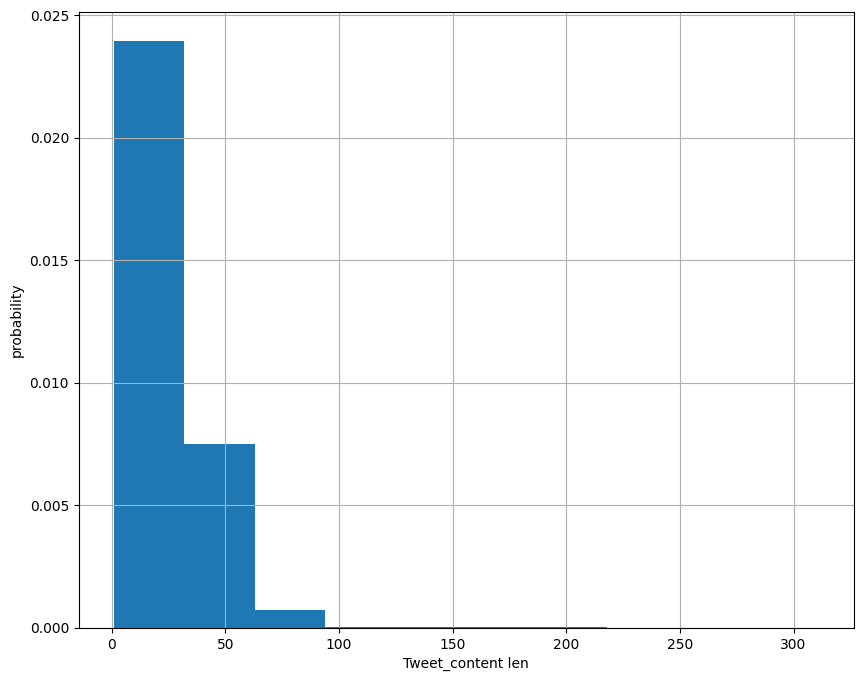

In [ ]:
Tweet_content_len = x.apply(lambda p: len(p.split(' ')))
max_Tweet_content_len = Tweet_content_len.max()
print('max Tweet_content len: {0}'.format(max_Tweet_content_len))
plt.figure(figsize = (10, 8))
plt.hist(Tweet_content_len, density = True)
plt.xlabel('Tweet_content len')
plt.ylabel('probability')
plt.grid()

In [ ]:
import re
import nltk
nltk.download('stopwords')  # Men-download stopwords
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
#1
def reviews(reviews):
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]

    return reviews
#2
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words
#3
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
y =data['Sentiment']

In [ ]:
#1
reviewtweet = reviews(x)
#2
no_stop_words_tweet = remove_stop_words(reviewtweet)
#3
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)

In [ ]:
stemmed_reviews_tweet[20]

'first borderland session long time actual enjoy realli satisfi combat experi . got rather good kill'

**Encoding**

In [ ]:
max_words = 8000


tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)
x = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
x = pad_sequences(x, maxlen = 300)


In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

y = np.array(label_tokenizer.texts_to_sequences(y))


# Model

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 42)

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 128, input_length = 300))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model_lstm.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=512,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 468s 4s/step - accuracy: 0.3286 - loss: 1.4093 - val_accuracy: 0.5636 - val_loss: 1.0606
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 484s 4s/step - accuracy: 0.5893 - loss: 1.0194 - val_accuracy: 0.6665 - val_loss: 0.8474
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 508s 4s/step - accuracy: 0.6980 - loss: 0.7881 - val_accuracy: 0.7152 - val_loss: 0.7323
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 443s 4s/step - accuracy: 0.7491 - loss: 0.6664 - val_accuracy: 0.7324 - val_loss: 0.6834
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.7746 - loss: 0.5997 - val_accuracy: 0.7499 - val_loss: 0.6524
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.7939 - loss: 0.5432 - val_accuracy: 0.7608 - val_loss: 0.6232
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.8064 - loss: 0.5123 - val_accuracy: 0.7676 - val_loss: 0.6087
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.8174 - loss: 0.4805 - val_accu

In [ ]:
model_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 300, 128)            │       1,024,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 300, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,518,225 (13.42 MB)

 Trainable params: 1,172,741 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,345,484 (8.95 MB)

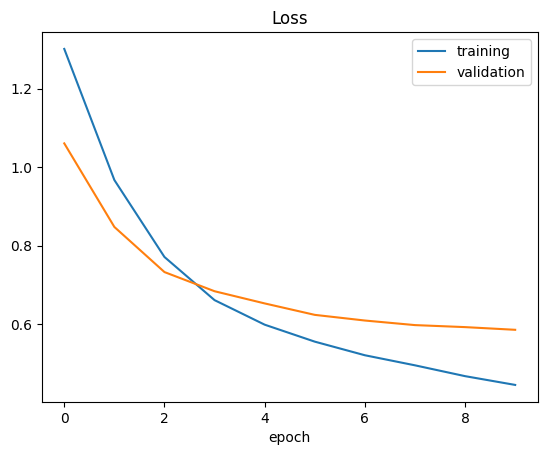

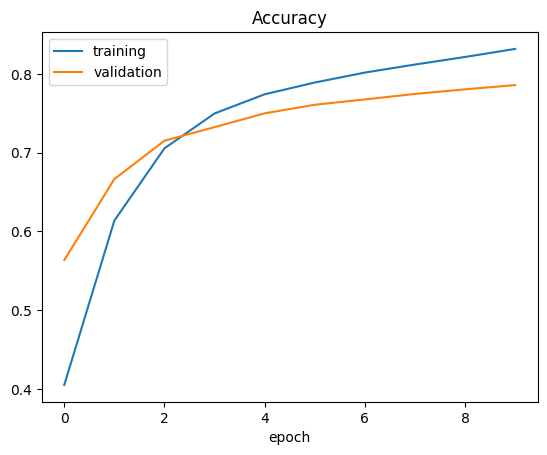

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()